<a href="https://colab.research.google.com/github/LukrecijaMedimorec/OSIRV/blob/main/VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%pip install medmnist

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [25]:
from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
from torch.optim import lr_scheduler
from torchsummary import summary
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import medmnist
from medmnist import INFO


In [3]:
info = INFO['bloodmnist']
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

DataClass = getattr(medmnist, info['python_class'])

In [4]:
transform = transforms.Compose([transforms.ToTensor()])

In [5]:
trainset = DataClass(split='train', transform=transform, download=True)
testset = DataClass(split='test', transform=transform, download=True)

train_dataloader = data.DataLoader(dataset=trainset, batch_size=128, shuffle=True)
train_eval_dataloader = data.DataLoader(dataset=trainset, batch_size=2*128, shuffle=False)
test_dataloader = data.DataLoader(dataset=testset, batch_size=2*128, shuffle=False)

Using downloaded and verified file: /home/lukrecija/.medmnist/bloodmnist.npz
Using downloaded and verified file: /home/lukrecija/.medmnist/bloodmnist.npz


In [6]:
classes = ('0', '1', '2', '3', '4', '5', '6', '7')

/tmp/ipykernel_3601/2591191304.py:8: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = int(label)


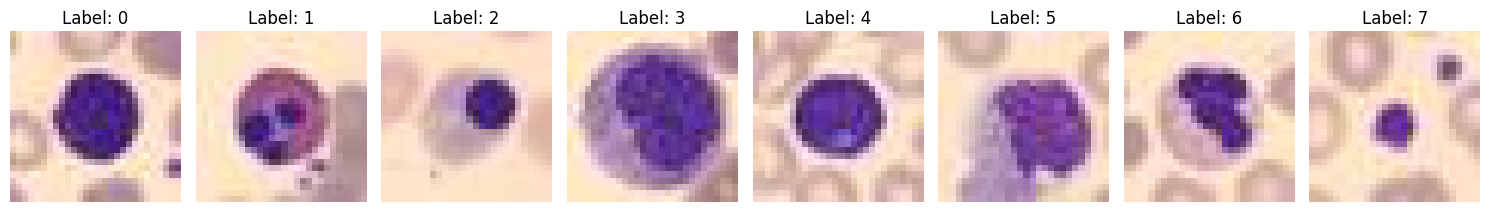

In [7]:
plt.figure(figsize=(15, 5))

encountered_labels = [False] * n_classes

for i in range(len(trainset)):
    image, label = trainset[i]

    label = int(label)

    if not encountered_labels[label]:
        plt.subplot(1, n_classes, label+1)
        plt.imshow(image.permute(1, 2, 0))
        plt.title(f'Label: {classes[label]}')
        plt.axis('off')

        encountered_labels[label] = True
    if all(encountered_labels):
        break

plt.tight_layout()
plt.show()

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [9]:
class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=2, padding=1),
            nn.ReLU()
            #nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=2, padding=1),
            #nn.ReLU()
        )

    def forward(self, x):
        x = self.encoder(x)
        return x

class Decoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.decoder = nn.Sequential(
            #nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=3, stride=2, padding=1, output_padding=1),
            #nn.ReLU(),
            nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=16, out_channels=3, kernel_size=3, stride=1, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.decoder(x)
        return x

class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()

    def forward(self, x):
        latent = self.encoder(x)
        reconstruction = self.decoder(latent)
        return reconstruction

model = Autoencoder()
model.to(device)


Autoencoder(
  (encoder): Encoder(
    (encoder): Sequential(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (3): ReLU()
      (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (5): ReLU()
    )
  )
  (decoder): Decoder(
    (decoder): Sequential(
      (0): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
      (1): ReLU()
      (2): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
      (3): ReLU()
      (4): ConvTranspose2d(16, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (5): Sigmoid()
    )
  )
)

In [10]:
summary(model, (3, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 28, 28]             448
              ReLU-2           [-1, 16, 28, 28]               0
            Conv2d-3           [-1, 32, 14, 14]           4,640
              ReLU-4           [-1, 32, 14, 14]               0
            Conv2d-5             [-1, 64, 7, 7]          18,496
              ReLU-6             [-1, 64, 7, 7]               0
           Encoder-7             [-1, 64, 7, 7]               0
   ConvTranspose2d-8           [-1, 32, 14, 14]          18,464
              ReLU-9           [-1, 32, 14, 14]               0
  ConvTranspose2d-10           [-1, 16, 28, 28]           4,624
             ReLU-11           [-1, 16, 28, 28]               0
  ConvTranspose2d-12            [-1, 3, 28, 28]             435
          Sigmoid-13            [-1, 3, 28, 28]               0
          Decoder-14            [-1, 3,

In [11]:
def visualize_samples(inputs, outputs):
    inputs = inputs.cpu().numpy()
    outputs = outputs.cpu().numpy()

    fig, axes = plt.subplots(nrows=2, ncols=5, sharex=True, sharey=True, figsize=(10, 4))

    for i in range(5):
        input_image = inputs[i].transpose((1, 2, 0))  
        axes[0, i].imshow(input_image)
        axes[0, i].set_title("Input")
        axes[0, i].axis('off')

        output_image = outputs[i].transpose((1, 2, 0))  
        axes[1, i].imshow(output_image)
        axes[1, i].set_title("Output")
        axes[1, i].axis('off')

    plt.tight_layout()
    plt.show()


Epoch [1/20], Loss: 0.5400
Epoch [2/20], Loss: 0.4937
Epoch [3/20], Loss: 0.4910
Epoch [4/20], Loss: 0.4900
Epoch [5/20], Loss: 0.4890
Epoch [6/20], Loss: 0.4891
Epoch [7/20], Loss: 0.4885
Epoch [8/20], Loss: 0.4879
Epoch [9/20], Loss: 0.4882
Epoch [10/20], Loss: 0.4867
Epoch [11/20], Loss: 0.4865
Epoch [12/20], Loss: 0.4861
Epoch [13/20], Loss: 0.4866
Epoch [14/20], Loss: 0.4862
Epoch [15/20], Loss: 0.4856
Epoch [16/20], Loss: 0.4856
Epoch [17/20], Loss: 0.4855
Epoch [18/20], Loss: 0.4851
Epoch [19/20], Loss: 0.4858
Epoch [20/20], Loss: 0.4849


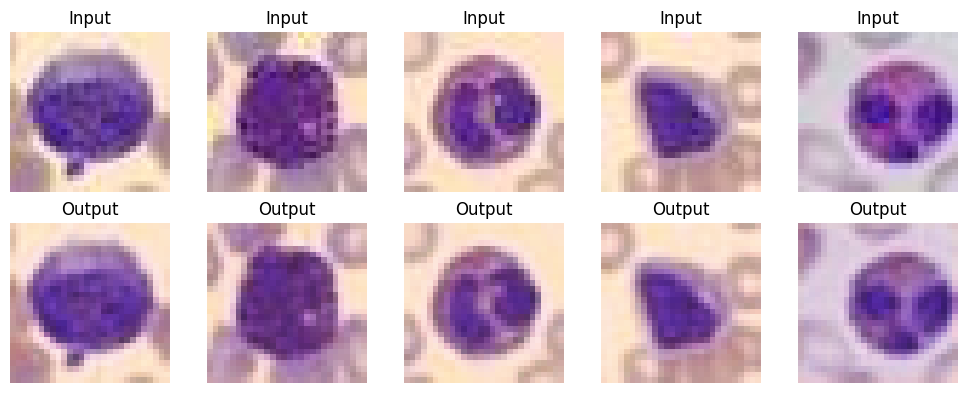

Training complete


In [12]:
def train(model, dataloader, num_epochs=10, lr=0.01):
    criterion=nn.BCELoss()
    optimizer=optim.Adam(model.parameters(), lr=lr)
    scheduler=lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
    device=torch.device("cpu")
    model.to(device)


    for epoch in range(num_epochs):
        total_loss=0.0
        for data in dataloader:
            inputs, _ = data
            inputs=inputs.to(device)
            optimizer.zero_grad()
            outputs=model(inputs)
            loss=criterion(outputs, inputs)
            loss.backward()
            optimizer.step()
            scheduler=lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

            total_loss+=loss.item()

        average_loss=total_loss/len(dataloader)
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {average_loss:.4f}")

        with torch.no_grad():
            model.eval()
            sample_inputs,_=next(iter(test_dataloader))
            reconstructions=model(sample_inputs)

    visualize_samples(sample_inputs, reconstructions)
    print("Training complete")

train(model, train_dataloader, 20)

## s klasama

In [22]:
class Encoder(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.num_classes = num_classes
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=3 + num_classes, out_channels=16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=2, padding=1),
            nn.ReLU()
        )

    def forward(self, x, labels):
        labels = labels.view(labels.size(0), self.num_classes, 1, 1).expand(-1, -1, x.size(2), x.size(3))
        x = torch.cat((x, labels), dim=1)
        x = self.encoder(x)
        return x

class Decoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=16, out_channels=3, kernel_size=3, stride=1, padding=3),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.decoder(x)
        return x

class Autoencoder(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.encoder = Encoder(num_classes)
        self.decoder = Decoder()

    def forward(self, x, labels):
        latent = self.encoder(x, labels)
        reconstruction = self.decoder(latent)
        return reconstruction

num_classes = 8
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Autoencoder(num_classes)
model.to(device)


Autoencoder(
  (encoder): Encoder(
    (encoder): Sequential(
      (0): Conv2d(11, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (3): ReLU()
      (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (5): ReLU()
      (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (7): ReLU()
    )
  )
  (decoder): Decoder(
    (decoder): Sequential(
      (0): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
      (1): ReLU()
      (2): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
      (3): ReLU()
      (4): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
      (5): ReLU()
      (6): ConvTranspose2d(16, 3, kernel_size=(3, 3), stride=(1, 1), padding=(3, 3))
      (7): Sigmoid()
    )
  )


Epoch [1/50], Loss: 0.5295
Epoch [2/50], Loss: 0.5124
Epoch [3/50], Loss: 0.5120
Epoch [4/50], Loss: 0.5115
Epoch [5/50], Loss: 0.5113
Epoch [6/50], Loss: 0.5113
Epoch [7/50], Loss: 0.5113
Epoch [8/50], Loss: 0.5110
Epoch [9/50], Loss: 0.5115
Epoch [10/50], Loss: 0.5109
Epoch [11/50], Loss: 0.5108
Epoch [12/50], Loss: 0.5109
Epoch [13/50], Loss: 0.5107
Epoch [14/50], Loss: 0.5108
Epoch [15/50], Loss: 0.5108
Epoch [16/50], Loss: 0.5109
Epoch [17/50], Loss: 0.5109
Epoch [18/50], Loss: 0.5106
Epoch [19/50], Loss: 0.5106
Epoch [20/50], Loss: 0.5104
Epoch [21/50], Loss: 0.5105
Epoch [22/50], Loss: 0.5105
Epoch [23/50], Loss: 0.5106
Epoch [24/50], Loss: 0.5104
Epoch [25/50], Loss: 0.5104
Epoch [26/50], Loss: 0.5104
Epoch [27/50], Loss: 0.5103
Epoch [28/50], Loss: 0.5103
Epoch [29/50], Loss: 0.5103
Epoch [30/50], Loss: 0.5103
Epoch [31/50], Loss: 0.5103
Epoch [32/50], Loss: 0.5102
Epoch [33/50], Loss: 0.5102
Epoch [34/50], Loss: 0.5102
Epoch [35/50], Loss: 0.5102
Epoch [36/50], Loss: 0.5101
E

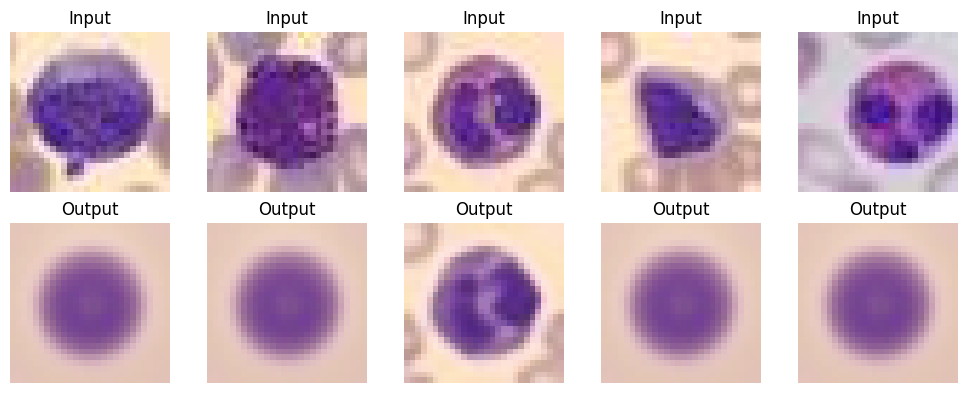

Training complete


In [24]:
def train(model, dataloader, num_epochs=10, lr=0.01, num_classes=8):
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    for epoch in range(num_epochs):
        total_loss = 0.0
        for data in dataloader:
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)

            
            conditioning_labels = torch.zeros(labels.size(0), num_classes).to(device)
            conditioning_labels.scatter_(1, labels.view(-1, 1), 1)

            optimizer.zero_grad()
            outputs = model(inputs, conditioning_labels.unsqueeze(-1).unsqueeze(-1))  
            loss = criterion(outputs, inputs)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        average_loss = total_loss / len(dataloader)
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {average_loss:.4f}")

        scheduler.step()

        
        with torch.no_grad():
            model.eval()
            sample_inputs, _ = next(iter(test_dataloader))
            sample_inputs = sample_inputs.to(device)
            sample_labels = torch.randint(0, num_classes, (sample_inputs.size(0),)).to(device)
            conditioning_labels = torch.zeros(sample_labels.size(0), num_classes).to(device)
            conditioning_labels.scatter_(1, sample_labels.view(-1, 1), 1)
            reconstructions = model(sample_inputs, conditioning_labels.unsqueeze(-1).unsqueeze(-1))  

    visualize_samples(sample_inputs, reconstructions)

    print("Training complete")

num_classes = 8
train(model, train_dataloader, num_epochs=50, num_classes=num_classes)
